In [1]:
from glob import glob

In [2]:
# Yolov5 format
# https://docs.cogniflow.ai/en/article/how-to-create-a-dataset-for-object-detection-using-the-yolo-labeling-format-1tahk19/
# https://towardsdatascience.com/the-practical-guide-for-object-detection-with-yolov5-algorithm-74c04aac4843

#https://blog.paperspace.com/train-yolov5-custom-data/

In [4]:
annotations_path = "/work/csr33/ast/complete-dataset/chips_positive_corrected_xml"
a = glob(annotations_path + "/*.xml")

In [6]:
len(a)

27639

In [4]:
save_dir="/work/csr33/ast"
path_to_predefined_classes="/work/csr33/ast/predefined_classes.txt"
# Get the annotations
annotations_path_yolov5 = "/work/csr33/ast/complete-dataset-yolov5/labels"

# Dictionary that maps class names to IDs
class_name_to_id_mapping = get_label_map(save_dir, path_to_predefined_classes)

In [ ]:
!cp -r "/work/csr33/ast/complete-dataset/chips_positive/." "/work/csr33/ast/complete-dataset-yolov5/images"

In [5]:
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join(annotations_path_yolov5, x) for x in os.listdir(annotations_path_yolov5) if x[-3:] == "txt"]

100%|██████████| 27639/27639 [13:45<00:00, 33.47it/s]


In [6]:
#Testing the annotations
random.seed(0)
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

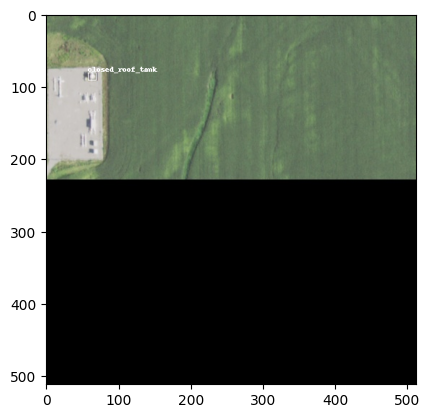

In [7]:
#Gut Check: check to make sure new annotatiosn are correct 
#Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
#image_file = '/work/csr33/ast/complete-dataset/chips_positive/'+os.path.basename(annotation_file).replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# Partition the Dataset


In [16]:
#Next we partition the dataset into train, validation, and test sets containing 80%, 10%, and 10% of the data, respectively. 
#You can change the split values according to your convenience.
images_path_yolov5 = "/work/csr33/ast/complete-dataset-yolov5/images"
# Read images and annotations
images = [os.path.join(images_path_yolov5, x) for x in os.listdir(images_path_yolov5)]
annotations = [os.path.join(annotations_path_yolov5, x) for x in os.listdir(annotations_path_yolov5) if x[-3:] == "txt"]
images.sort()
annotations.sort()

In [15]:
len(os.listdir(images_path_yolov5))

27639

In [17]:
# Set the split ratios (adjust as needed)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = (1 - train_ratio), random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = (test_ratio / (1 - train_ratio)), random_state = 1)

In [18]:
dataset_for_object_detection = "/work/csr33/ast/datasets/ast_yolov5"
data_type = ["images", "labels"]
split = ["train", "val", "test"]
for d in data_type:
    for s in split:
        directory_path =  os.path.join(dataset_for_object_detection, d, s)
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

In [19]:
#Move the files to their respective folders.

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, os.path.join(dataset_for_object_detection, "images", "train"))
move_files_to_folder(val_images, os.path.join(dataset_for_object_detection, "images", "val"))
move_files_to_folder(test_images, os.path.join(dataset_for_object_detection, "images", "test"))
move_files_to_folder(train_annotations, os.path.join(dataset_for_object_detection, "labels", "train"))
move_files_to_folder(val_annotations, os.path.join(dataset_for_object_detection, "labels", "val"))
move_files_to_folder(test_annotations, os.path.join(dataset_for_object_detection, "labels", "test"))

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data ast.yaml --weights yolov5s.pt --workers 24 --name yolo_ast_det

## Training Options
